Dataset cleaning

## Table des matières

1. **[Idée de l'application](#app_idea)**
2. **[Initialisation et chargement des données](#init)**
3. **[Filtrage des produits français](#french)**
4. **[Pré-sélection des variables](#preselection)**
5. **[Analyse des variables pré-sélectionnées](#preselection-analysis)**
    1. [Scores nutritionnels](#nutriscores)
    2. [Colonnes des catégories et tags](#categories)
    3. [Label biologique](#organic_label)
    4. [Colonnes d'énergie](#energy-columns)
    5. [Colonnes de sel et sodium](#salt_sodium)
6. **[Traitement des valeurs aberrantes et atypiques](#aberrant_atypical)**
    1. [Scores nutritionnels](#atypical_nutriscores)
    2. [Colonne d'énergie](#atypical_energies)
    3. [Colonnes nutritionnelles](#atypical_nutritional)
7. **[Traitement des valeurs manquantes](#missing_values)**
    1. [Suppression des lignes vides](#missing_empty_lines)
    2. [Suppression des produits sans nom](#empty_product_names)
    3. [Colonnes nutritionnelles](#empty_nutritional)
    4. [Autres colonnes](#missing_others)
8. **[Exportation des données](#export)**

## 1. Idée de l'application <a name="app_idea"></a>
L'idée ici est de créer une application qui, à partir d'un produit donné, permettra de :  
* Suggérer des produits similaires mais biologiques (si possible) ou avec un meilleur nutriscore.  
* Afficher toutes les informations nutritionnelles des produits à l'aide de graphiques radar (plus complets que le simple score).  

## 2. Initialisation du notebook et chargement des données<a name="init"></a>

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import math

sns.set()
pd.set_option('display.max_columns', None)

In [ ]:
import re
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
from sklearn import feature_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn import neighbors

NUTRIGRADE_COLORS = {
    'A': 'forestgreen',
    'B': 'lawngreen',
    'C': 'gold',
    'D': 'darkorange',
    'E': 'firebrick'
}

NUTRIGRADE_XTICKS = {
    'A': 'A [-15;0[',
    'B': 'B [0;3[',
    'C': 'C [3;11[',
    'D': 'D [11;19[',
    'E': 'E [19;40]'
}

def get_nutriscore_letter(score):
    ''' Returns the nutrigrade letter according to the numeric nutriscore '''
    if score < 0:
        return 'A'
    elif score < 3:
        return 'B'
    elif score < 11:
        return 'C'
    elif score < 19: 
        return 'D'
    else:
        return 'E'
    
def get_nutritional_columns(data, exclude_starts=[]):
    ''' Explore the data columns to return the columns names that seems to be nutritional columns '''
    if len(exclude_starts) > 0:
        regexp = '^(?!'
        for index, start in enumerate(exclude_starts):
            if index > 0:
                regexp = regexp + '|'
            regexp = regexp + '(' + start + ')'
        regexp = regexp + ').*_100g$'
    else:
        regexp = '^.*_100g$'
            
    return [x for x in data.columns.values if re.match(regexp, x)]


def get_variables_with_filling_percentage(filled_data, min=0, max=100):
    ''' Return the filled data with only a certain percentages of filling
    
        Parameters:
        filled_data (pd.series): the list of all the variables with one column containing their filling percentage
        min (int): the minimum filling percentage to keep (included)
        max (int): the maximum fulling percentage to keep (excluded except if = 100%)

        Returns:
        pd.series: the filtered variables
    '''
    if max == 100:
        max = 101
    plot_variables = filled_data.to_frame()
    plot_variables = plot_variables[(plot_variables[0] >= min) & (plot_variables[0] < max)]
    
    return plot_variables


def plot_variables_filling_percentage(filled_data, min=0, max=100, ax=None, color="blue"):
    ''' Plot the horizontal bar chart of the variables with a filling percentage between min and max 
        
        Parameters:
            filled_data (list) : a list containing the data name and filling percentages
            min (int) : the minimum percentage to display (included)
            max (int) : the maximum percentage to display (excluded)
            ax (plt.Axes) : the plt axe on which plot
            color (string) : the color of the bars
    '''
    if ax == None:
        ax = plt.gca()
    
    plot_variables = get_variables_with_filling_percentage(filled_data, min, max)
    
    plot_variables.plot(kind='barh', 
                        xlim=(min,max),
                        fontsize=15,
                        ax=ax,
                        color=color)
    ax.set_title("Variables with a filling percentage between " + str(min) + "% and " + str(max) + "%", fontsize=20)
    ax.set_xlabel("Filling percentage (France data only)", fontsize=20)
    ax.tick_params(axis="y", direction="out", labelcolor=color)
    ax.invert_yaxis()
    
def extract_country_code(tag):
    ''' Extract the 2-letters country code at the beginning of a tag string
        
        Parameters:
            tag (string)
    '''
    tag_parts = tag.split(':')
    if len(tag_parts) > 1 and re.match('^[a-z]{2}$', tag_parts[0]):
        return tag_parts[0]
    return math.nan

In [89]:
data = pd.read_csv('../input/enopenfoodfactsorgproducts/en.openfoodfacts.org.products.csv', sep='\t', low_memory=False)

## 3. Filtrage des produits français<a name="french"></a>
L'objectif de notre application est de suggérer des produits similaires. De plus, nous souhaitons utiliser autant que possible le nutriscore français. C'est pourquoi nous décidons ici de **conserver uniquement les produits français** pour notre étude.

Pour ce faire, examinons la colonne **countries**. Nous pouvons remarquer que chaque pays peut être représenté sous au moins deux formes différentes, insensibles à la casse :  
* Le nom du pays lui-même : "France" ou "france"  
* Le code du pays ("fr" pour la France) suivant un autre nom/code de pays (séparés par un deux-points) : "en:fr" par exemple.

Nous utilisons donc des expressions régulières pour isoler ces deux cas et filtrer nos données afin de ne conserver que les produits français.

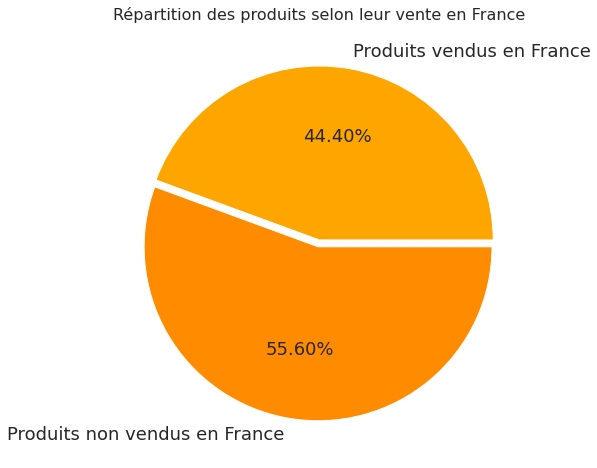

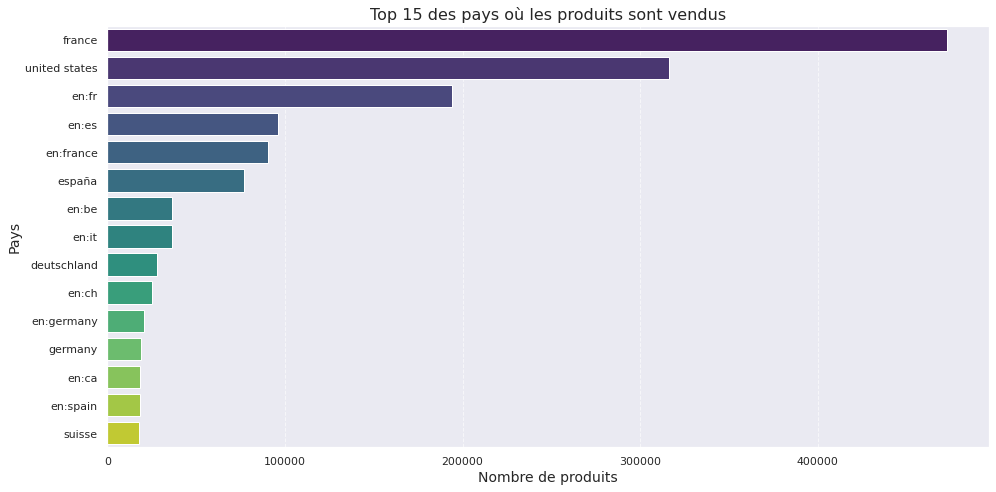

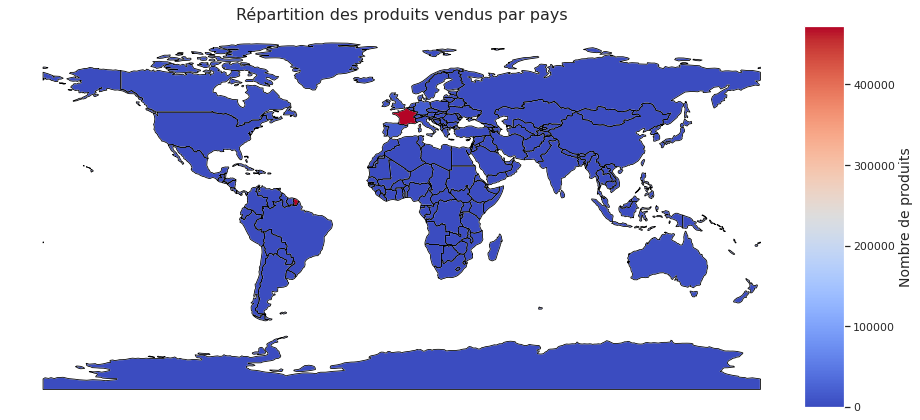

In [ ]:
applied_filters = {'Jeu de données initial': len(data)}

data['sold_in_france'] = data['countries'].str.contains('(?:France)|(?::fr)', case=False, regex=True)

total_french_products = len(data[data['sold_in_france'] == True])
total_not_french_products = len(data) - total_french_products

fig, ax = plt.subplots(figsize=[10, 8])
plt.pie(x=[total_french_products, total_not_french_products], 
        autopct="%.2f%%", 
        labels=["Produits vendus en France", "Produits non vendus en France"], 
        colors=['orange', 'darkorange'],
        explode=[0.02, 0.02],
        textprops={'size': 18})
plt.title("Répartition des produits selon leur vente en France", fontsize=16)

data_france = data[data['sold_in_france'] == True].copy()

applied_filters['Produits français'] = len(data_france)

countries_series = data['countries'].dropna().str.lower().str.split(',')

all_countries = countries_series.explode().str.strip()

country_counts = all_countries.value_counts().sort_values(ascending=False)

top_countries = country_counts.head(15)

plt.figure(figsize=(14, 7))
sns.barplot(x=top_countries.values, y=top_countries.index, palette="viridis")
plt.title("Top 15 des pays où les produits sont vendus", fontsize=16)
plt.xlabel("Nombre de produits", fontsize=14)
plt.ylabel("Pays", fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import geopandas.tools
from shapely.geometry import Point

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

world['count'] = 0

for country, count in country_counts.items():
        if country in world['name'].str.lower().values:
                world.loc[world['name'].str.lower() == country, 'count'] = count

norm = Normalize(vmin=world['count'].min(), vmax=world['count'].max())
cmap = plt.cm.coolwarm

fig, ax = plt.subplots(1, 1, figsize=(15, 10))

world.boundary.plot(ax=ax, linewidth=0.8, color='black')
world.plot(column='count', ax=ax, legend=False, cmap=cmap, norm=norm)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cax)
cbar.set_label('Nombre de produits', fontsize=14)

ax.set_title("Répartition des produits vendus par pays", fontsize=16)
ax.set_axis_off()

plt.show()

In [ ]:
data['sold_in_us'] = data['countries'].str.contains('(?:United States)|(?:us)', case=False, regex=True)
data_us = data[data['sold_in_us'] == True]
data_france = data[data['sold_in_france'] == True]

top_products_us = data_us['product_name'].value_counts().head(10)
top_products_france = data_france['product_name'].value_counts().head(10)

print("Top 10 products sold in the US:")
print(top_products_us)

print("\nTop 10 products sold in France:")
print(top_products_france)

Top 10 products sold in the US:
Ice cream                 711
Soda                      477
Potato chips              370
Premium ice cream         314
Ice Cream                 279
100% juice                254
Popcorn                   247
Salsa                     236
Cookies                   235
Extra virgin olive oil    229
Name: product_name, dtype: int64

Top 10 products sold in France:
Comté                         870
Filet de poulet               868
Miel                          664
Filets de poulet              581
Chocolat                      559
Emmental                      550
Poulet                        549
Huile d'olive vierge extra    520
Huile d'olive                 501
Escalope de dinde             500
Name: product_name, dtype: int64


## 4. Pré-sélection de nos variables<a name="preselection"></a>
Nous utilisons la [liste des variables](https://world.openfoodfacts.org/data/data-fields.txt) disponible sur le site d'OFF.

Pour créer notre application, nous aimerions disposer des types de variables suivants :  
* Le **nom du produit**  
* Diverses **informations nutritionnelles** pour créer nos graphiques radar  
* Les **labels** pour identifier un éventuel label biologique  
* Le **nutriscore français du produit** pour comparer les produits  
* Les **catégories de produits** afin de comprendre le type de produit  
* Éventuellement une **image du produit** pour rendre l'affichage plus attrayant  

### 4.1 Exploration des pourcentages de valeurs manquantes pour chaque colonne
Calculons le pourcentage de valeurs remplies pour chaque variable du jeu de données.

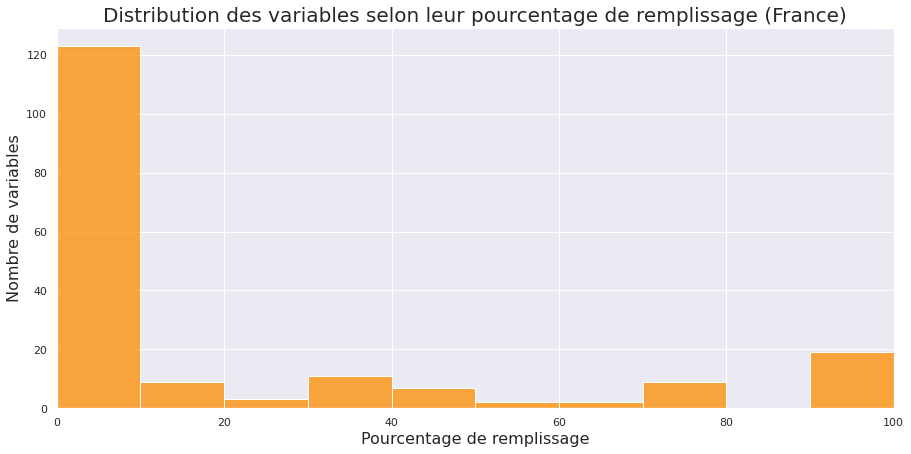

In [ ]:
filled_data = data_france.notnull().sum()
filled_data = filled_data * 100 / len(data_france)
filled_data = filled_data.sort_values(ascending=False)

plt.figure(figsize=(15,7))
sns.histplot(filled_data, bins=10, color="darkorange")
plt.title("Distribution des variables selon leur pourcentage de remplissage (France)", fontsize=20)
plt.xlabel("Pourcentage de remplissage", fontsize=16)
plt.ylabel("Nombre de variables", fontsize=16)

axes = plt.gca()
axes.set_xlim([0, 100])
axes.set_ylim([0, None])

plt.grid(True)
plt.show()

**Conclusion** : la plupart des variables sont remplies à moins de 10%, ce qui les rend très peu intéressantes pour notre analyse.

Passons maintenant à l'exploration des variables les mieux remplies du jeu de données.

### 4.2 Exploration du remplissage des données / valeurs manquantes (NaN)

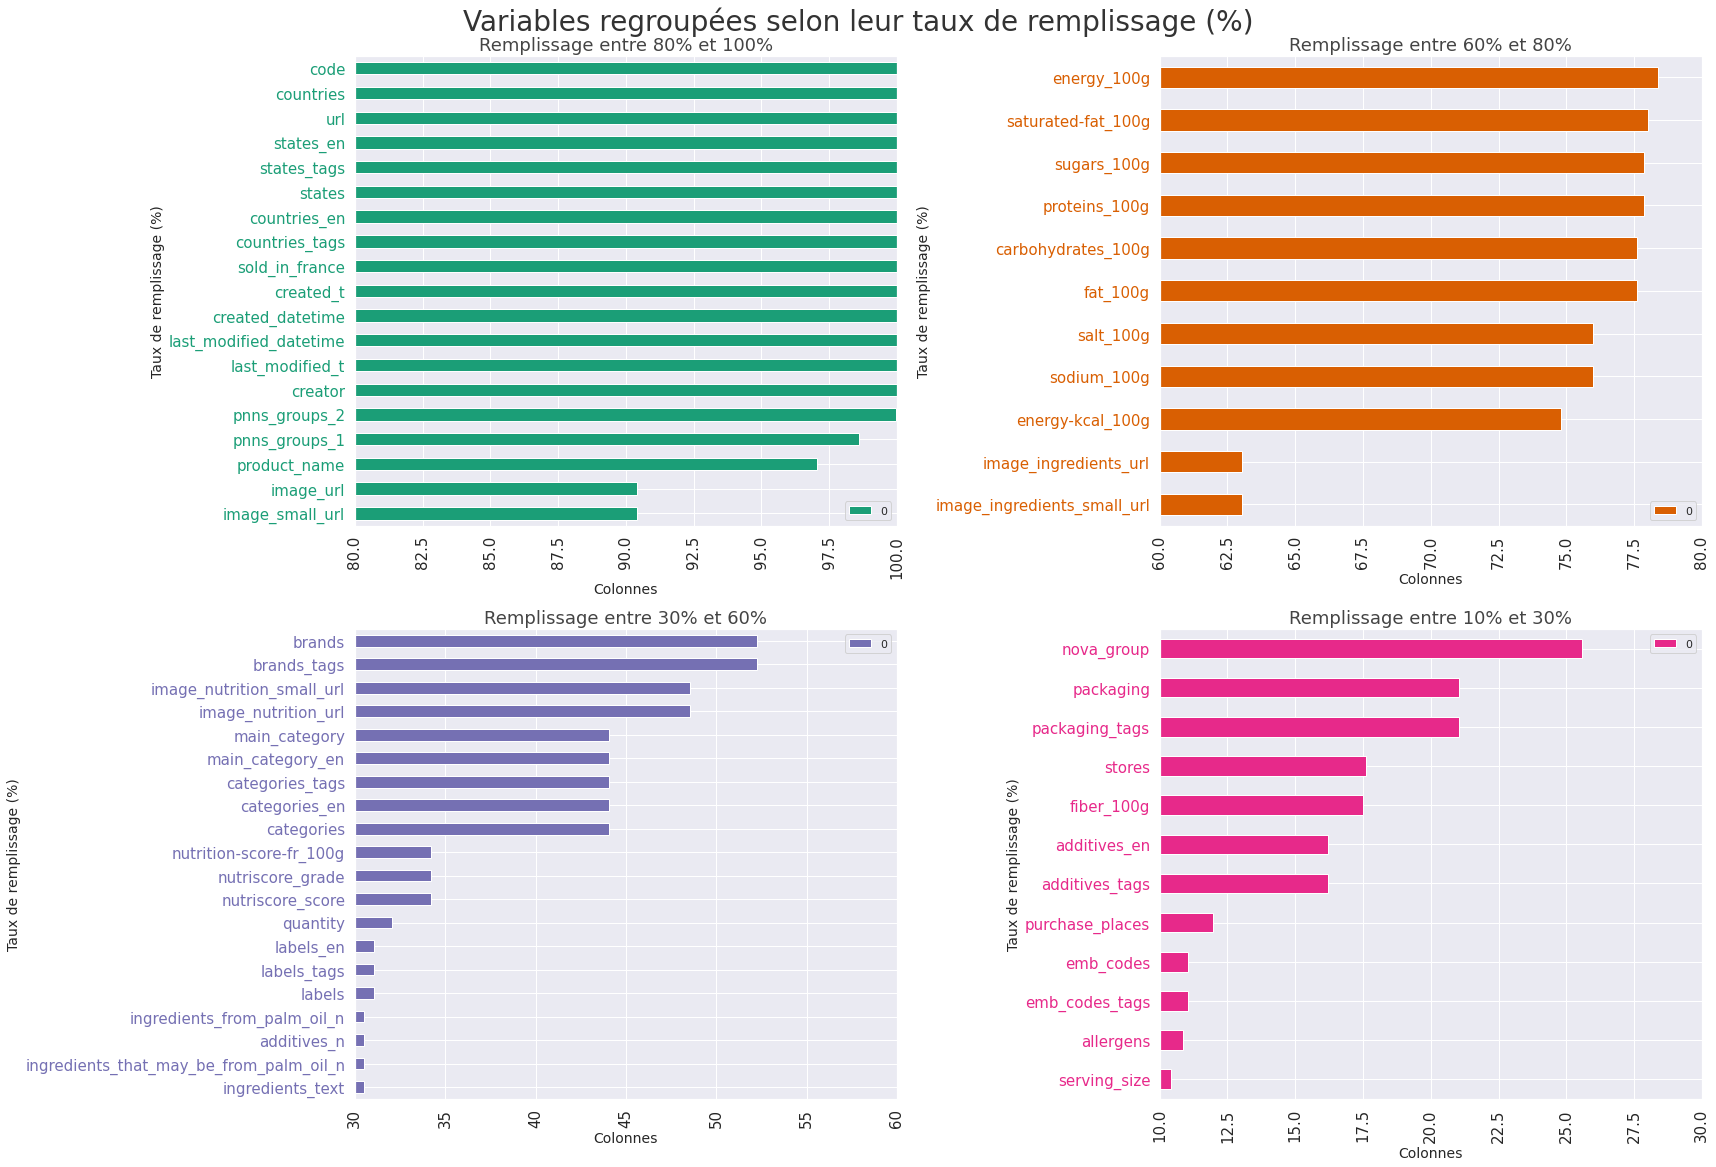

In [ ]:
fig, axes = plt.subplots(figsize=(24, 18), nrows=2, ncols=2)
fig.suptitle("Variables regroupées selon leur taux de remplissage (%)", fontsize=28, y=0.93, color="#333333")
fig.subplots_adjust(hspace=0.25, wspace=0.3)

couleurs = ["#1b9e77", "#d95f02", "#7570b3", "#e7298a"]
titres = [
    "Remplissage entre 80% et 100%",
    "Remplissage entre 60% et 80%",
    "Remplissage entre 30% et 60%",
    "Remplissage entre 10% et 30%"
]

seuils = [(80, 100), (60, 80), (30, 60), (10, 30)]
for i, (bas, haut) in enumerate(seuils):
    ax = axes[i // 2][i % 2]
    plot_variables_filling_percentage(
        filled_data, 
        bas, 
        haut, 
        ax=ax, 
        color=couleurs[i]
    )
    ax.set_title(titres[i], fontsize=18, color="#444444")
    ax.set_xlabel("Colonnes", fontsize=14)
    ax.set_ylabel("Taux de remplissage (%)", fontsize=14)
    ax.tick_params(axis='x', rotation=90)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

**Colonnes remplies à 80-100%** :  
* Toutes les variables remplies à 100% sont principalement des variables techniques d'OpenFoodFacts (code produit, dates, éditeurs, ...).  
* Les variables **pnns** contiennent des catégories alimentaires créées par le gouvernement français, mais il semble étrange qu'elles soient autant remplies. Nous allons vérifier cela.  
* Nous avons, comme souhaité, un **nom de produit**, une **url** et une **image_url** (qui est aussi remplie que **image_small_url**, que nous pouvons utiliser pour alléger le chargement des résultats de l'application).  

**Colonnes remplies à 60-80%** :  
* L'url de l'image des ingrédients du produit, qui n'est pas utile pour notre application.  
* De nombreuses informations nutritionnelles qui peuvent être utilisées pour afficher nos graphiques radar nutritionnels.  

Mais la question est : **toutes les informations nutritionnelles sont-elles présentes ici ?** Nous pouvons remarquer qu'elles se terminent toutes par "**_100g**". Vérifions donc toutes les variables avec ce motif qui ne sont pas présentes dans la liste ci-dessus.  

**Colonnes remplies à 30-60%** :  
* Il y a des variables **main_category**, **categories** et **categories_tags** qui peuvent être très utiles si les variables *pnns* ne sont pas suffisamment remplies.  
* Nous retrouvons le **nutrition-score-fr_100g** mentionné précédemment, ainsi qu'un **nutriscore_score** et un **nutriscore_grade** qui devraient être liés.  
* Les **labels** pour identifier, par exemple, des produits biologiques.  
* Certaines variables peuvent nous informer sur la présence d'**ingrédients à base d'huile de palme**, que nous pourrions utiliser pour discriminer deux produits (identifier lequel est plus sain).  

**Colonnes remplies à 16-30%** :  

Même si ces colonnes ne sont pas suffisamment remplies, l'une d'entre elles est intéressante et pourrait être utile pour le reste de notre analyse :  
* La **fiber_100g**, que nous inclurons dans notre graphique radar uniquement si elle est disponible.  

Vérifions maintenant les valeurs à l'intérieur des colonnes pnns.

#### Validation des colonnes PNNS

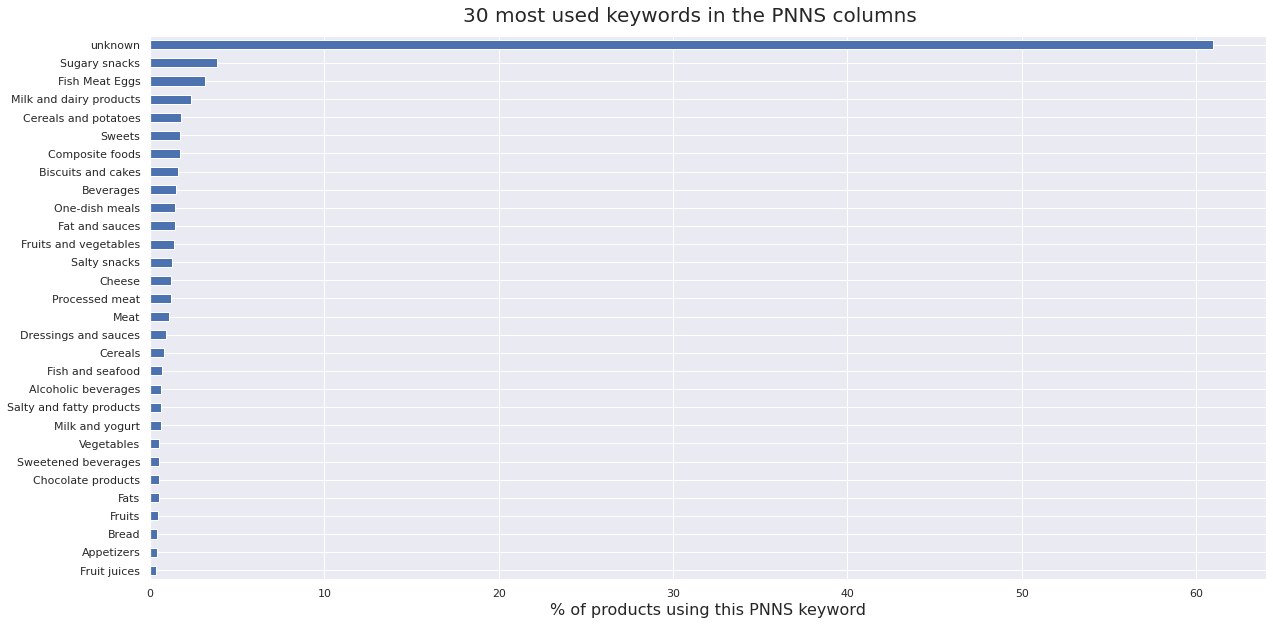

In [ ]:
pnns = (pd.concat([data_france['pnns_groups_1'], data_france['pnns_groups_2']])).value_counts()

pnns = pnns * 100 / (len(data_france) * 2)

pnns_plot_size = 30
pnns[:pnns_plot_size].plot(kind='barh', figsize=(20,10))
plt.gcf().suptitle(str(pnns_plot_size) + " most used keywords in the PNNS columns", fontsize=20, y=0.92)
plt.gca().set_xlabel("% of products using this PNNS keyword", fontsize=16)
plt.gca().invert_yaxis()

Nous remarquons que le mot-clé "**unknown**" est utilisé dans 80% des cas. En réalité, les variables PNNS sont donc vides à 80%. Nous allons remplacer les valeurs "unknown" par des valeurs NaN pour le reste de l'analyse.

In [ ]:
data_france.loc[data_france['pnns_groups_1'] == 'unknown', 'pnns_groups_1'] = np.nan
data_france.loc[data_france['pnns_groups_2'] == 'unknown', 'pnns_groups_2'] = np.nan

100 * (data_france['pnns_groups_1'].notnull().sum() + data_france['pnns_groups_2'].notnull().sum()) / (2 * len(data_france))

38.339868381526834

### 4.3 Liste finale des variables pré-sélectionnées

In [95]:
display_variables = ['url', 'product_name', 'image_small_url']
category_variables = ['main_category', 'categories', 'categories_tags']
label_variables = ['labels', 'labels_tags']
nutriscore_variables = ['nutrition-score-fr_100g', 'nutriscore_score', 'nutriscore_grade']
calculation_variables = ['energy_100g', 'saturated-fat_100g', 'sugars_100g', 'proteins_100g', 'fat_100g',
                        'carbohydrates_100g', 'salt_100g', 'sodium_100g', 'energy-kcal_100g', 'fiber_100g']

## 5. Analyse de nos variables pré-sélectionnées<a name="preselection-analysis"></a>
Dans cette partie, nous allons tenter de répondre à ces questions :
* **Les 3 colonnes "nutriscore" sont-elles toutes essentielles** ou pouvons-nous les réduire pour n'en conserver qu'une seule ?
* Même question pour les catégories et les labels ?
* Pouvons-nous **déterminer le pourcentage de fibres en utilisant les autres colonnes** ?

### 5.1 Comparaison des indicateurs de score nutritionnel<a name="nutriscores"></a>

Text(0.5, 1.05, 'Nutrition score distribution and correlation to nutriscore_score column')

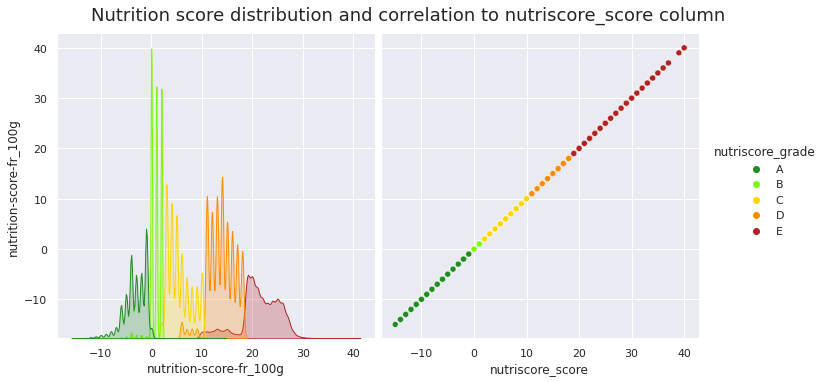

In [96]:
data_france.loc[:, 'nutriscore_grade'] = data_france['nutriscore_grade'].str.upper()
nutriscore_data = data_france[nutriscore_variables]
pairplot = sns.pairplot(nutriscore_data, 
             x_vars=["nutrition-score-fr_100g", "nutriscore_score"],
             y_vars=["nutrition-score-fr_100g"],
             hue='nutriscore_grade', 
             hue_order=['A', 'B', 'C', 'D', 'E'],
             palette=NUTRIGRADE_COLORS,
             height=5)
pairplot.fig.suptitle('Nutrition score distribution and correlation to nutriscore_score column', y=1.05, fontsize=18)

Ces graphiques nous donnent plusieurs informations :
* Les colonnes **nutriscore_score et nutrition-score-fr_100g sont identiques**. Nous remarquons une ligne droite parfaite entre les deux, avec un angle de 45° et une origine à 0. Cela signifie que nos deux colonnes contiennent les mêmes valeurs.

* Nous remarquons également les différentes couleurs sur ces lignes droites qui **confirment les tranches du nutriscore français** :
    * **Grade A** : de -15 à -1
    * **Grade B** : de 0 à 2
    * **Grade C** : de 3 à 10
    * **Grade D** : de 11 à 18
    * **Grade E** : de 19 à 40

* Les deux histogrammes montrent les **erreurs dans les nutriscore_grade** : les différentes couleurs devraient être parfaitement séparées selon les tranches ci-dessus, mais ce n'est pas le cas.

**CONCLUSION** : nous pouvons conserver une seule de ces trois colonnes, et **nous garderons la colonne nutrition-score-fr_100g** car elle est légèrement plus remplie. Nous réassignerons un nutriscore_grade en utilisant les tranches officielles du nutriscore.

Mais avant de supprimer la colonne *nutriscore_score*, vérifions s'il existe des produits pour lesquels cette colonne est remplie mais pas la colonne *nutrition-score-fr_100g* :


In [97]:
len(data_france[(data_france['nutriscore_score'].notnull()) & (data_france['nutrition-score-fr_100g'].isnull())])

0

Notre choix est bon, et il n'est pas nécessaire de fusionner les 2 colonnes.

### 5.2 Sélection d'une ou plusieurs colonnes de catégories<a name="categories"></a>
Nous avons pré-sélectionné plusieurs colonnes de catégories, nous souhaitons maintenant les explorer et voir si l'une d'entre elles semble meilleure que les autres.

Tout d'abord, comparons leurs pourcentages de remplissage : nous remarquons que les **catégories** sont toutes remplies à environ 45%, ce qui est plutôt bien.

Regardons maintenant ce que contiennent ces colonnes :

In [98]:
categories_data = data_france[category_variables].dropna(how="all")
categories_data

,main_category,categories,categories_tags
3,en:mustards,"Epicerie, Condiments, Sauces, Moutardes","en:groceries,en:condiments,en:sauces,en:mustards"
4,fr:xsf,Xsf,fr:xsf
13,fr:pate-d-amende,Pâte d'amende,fr:pate-d-amende
14,en:seasoned-shredded-carrots,"Plats préparés, Légumes préparés, Carottes râp...","en:meals,en:prepared-vegetables,en:grated-carr..."
23,en:coconut-pies,"Tartes, Tartes sucrées, Tartes à la noix de coco","en:pies,en:sweet-pies,en:coconut-pies"
...,...,...,...
1701950,en:aromatic-rices,"Aliments et boissons à base de végétaux, Alime...","en:plant-based-foods-and-beverages,en:plant-ba..."
1701951,en:ground-beef-steaks,"Viandes, Bœuf, Steaks, Steaks de bœuf, Steaks ...","en:meats,en:beef,en:steaks,en:beef-steaks,en:g..."
1701954,en:sweet-fritters,"Snacks, Snacks sucrés, Beignets sucrés","en:snacks,en:sweet-snacks,en:sweet-fritters"
1701957,en:ground-beef-steaks,"Viandes, Bœuf, Steaks, Steaks de bœuf, Steaks ...","en:meats,en:beef,en:steaks,en:beef-steaks,en:g..."


#### Étude des valeurs de categories_tags

In [99]:
split_tags_count = (categories_data['categories_tags'].str.split(',', expand=True).stack().value_counts()).to_frame()
split_tags_count.columns = ['Nb of products']

# A tag could be used twice in a product but we do not consider this case below
split_tags_count['% of products'] = 100 * split_tags_count ['Nb of products'] / len(data_france)
split_tags_count

,Nb of products,% of products
en:plant-based-foods-and-beverages,94812,12.546763
en:plant-based-foods,81493,10.784219
en:snacks,50344,6.662176
en:sweet-snacks,42730,5.654592
en:beverages,41253,5.459136
...,...,...
en:ground-seeds,1,0.000132
en:beef-ribs,1,0.000132
fr:gateau-feuillete-puree-de-pommes,1,0.000132
fr:31kcal,1,0.000132


L'utilisation de chaque mot-clé est très variée, entre 12 % et 0,0001 %. Nous souhaitons maintenant savoir comment ils sont répartis.

Text(104.125, 0.5, 'Number of keywords')

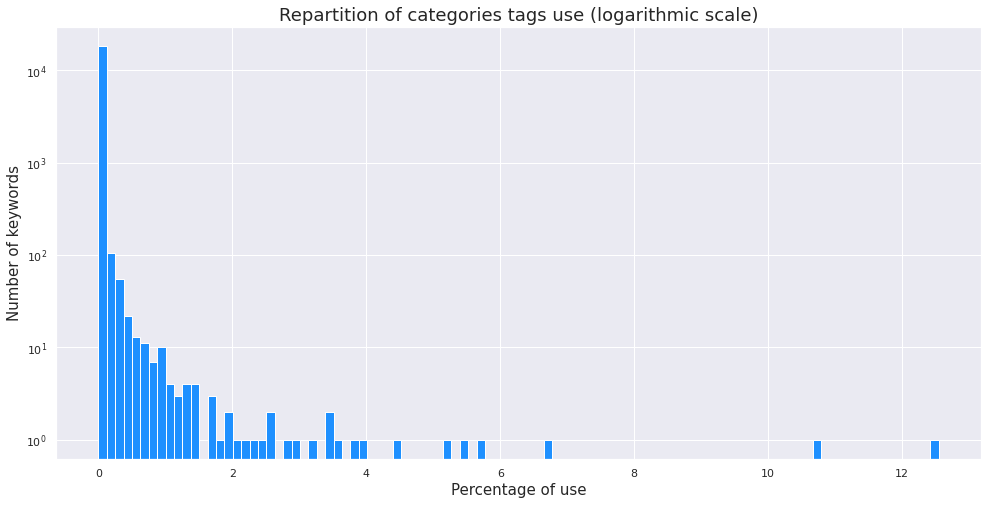

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))
fig.tight_layout(pad=5.0)

split_tags_count['% of products'].plot(kind="hist", ax=ax, color="dodgerblue", logy=True, bins=100)
ax.set_title("Repartition of categories tags use (logarithmic scale)", fontsize=18)
ax.set_xlabel("Percentage of use", fontsize=15)
ax.set_ylabel("Number of keywords", fontsize=15)

In [ ]:
once_percentage = round(100 * len(split_tags_count[split_tags_count['Nb of products'] == 1]) / len(split_tags_count),2)
print("Percentage of tags used only once : " + str(once_percentage) + "%")

Percentage of tags used only once : 53.96%


Ainsi, **53% des tags sont utilisés par un seul produit**. Nous les conservons néanmoins car il n'y a aucun intérêt à les remplacer par des NaN.

#### Étude des valeurs de main_category

Number of categories in the main_category column : 16346
Percentage of main_categories used only once : 54.65%


([<matplotlib.patches.Wedge at 0x7c0620641a10>,
 [Text(-0.16146273252505486, 1.0981938745073854, 'Used only once'),
  Text(-0.9174053048192831, -0.6248739926492689, 'Used less than 3 times'),
  Text(0.48478024829228716, -0.9985429939995916, 'Used more than 3 times')],
 [Text(-0.08873177192818328, 0.603511949053608, '54.6%'),
  Text(-0.5041596720178041, -0.3433992211856342, '9.7%'),
  Text(0.26641076707954514, -0.548748852558334, '35.6%')])

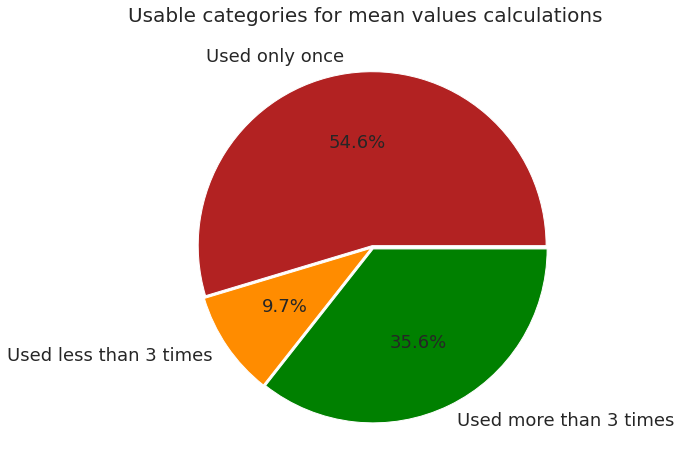

In [ ]:
print("Number of categories in the main_category column : " + str(len(data_france['main_category'].unique())))

categories_count = categories_data['main_category'].value_counts().to_frame()
once_percentage = round(100 * len(categories_count[categories_count['main_category'] == 1]) / len(categories_count),2)
print("Percentage of main_categories used only once : " + str(once_percentage) + "%")

USE_THRESHOLD=3
pie_chart_data = {
    'Used only once': len(categories_count[categories_count['main_category'] == 1]),
    'Used less than ' + str(USE_THRESHOLD) + ' times' : len(categories_count[(categories_count['main_category'] > 1) & (categories_count['main_category'] < USE_THRESHOLD)]),
    'Used more than ' + str(USE_THRESHOLD) + ' times' : len(categories_count[categories_count['main_category'] >= USE_THRESHOLD])
}

fig = plt.figure(figsize=(8,8))
plt.suptitle("Usable categories for mean values calculations", fontsize=20, y=0.92)
plt.pie(pie_chart_data.values(), 
        labels=pie_chart_data.keys(), 
        autopct="%.1f%%", 
        explode=[0.01]*3, 
        colors=["firebrick", "darkorange", "green"],
        textprops={'size': 18})

Cette fois encore, la plupart des catégories sont utilisées uniquement par un produit dans notre jeu de données.

Nous les conservons néanmoins, mais nous devons garder cela à l'esprit pour le traitement des valeurs manquantes en utilisant les moyennes des catégories principales.

### 5.3 Recherche du label biologique<a name="organic_label"></a>
Pour les labels biologiques, nous allons ajouter une colonne booléenne indiquant True si les labels contiennent "organic" ou "bio" (pour correspondre aux noms biologiques en français et en anglais).

([<matplotlib.patches.Wedge at 0x7c061ccb6590>,
 [Text(1.0481688251598134, 0.3946417539529963, 'Organic'),
  Text(0.2600564858777457, 1.0893900238908552, 'Non organic'),
  Text(-0.6272338530088504, -0.9278888368978646, 'N/A')],
 [Text(0.5802363139277537, 0.21846239950969432, '11.46%'),
  Text(0.1439598403966092, 0.6030551917967234, '19.62%'),
  Text(-0.3472187400584707, -0.5136527489970322, '68.92%')])

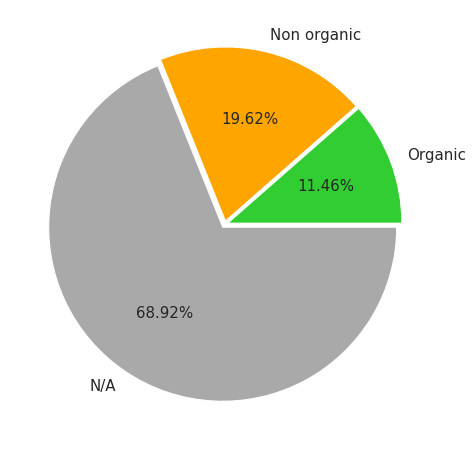

In [103]:
data_france['organic'] = data_france['labels'].str.contains('(?:organic)|(?:bio)', case=False, regex=True)
total_organic_products = len(data_france[data_france['organic'] == True])
total_non_organic_products = len(data_france[data_france['organic'] == False])
total_null_organic_products = len(data_france[data_france['organic'].isnull() == True])

plt.figure(figsize=(8,8))
plt.pie([total_organic_products, total_non_organic_products, total_null_organic_products],
        autopct="%.2f%%", 
        labels=["Organic", "Non organic", "N/A"], 
        colors=['limegreen', 'orange', 'darkgrey'],
        explode=[0.02]*3,
        textprops={'size': 15})

### 5.4 Comparaison des colonnes d'énergie<a name="energy-columns"></a>
Dans cette partie, nous allons comparer les deux colonnes d'énergie : l'une en kilo-Joule (kJ) et l'autre en kilo-calorie (kcal).

La définition du kcal est : **1 kcal = 4,184 kJ**. Voyons si nous pouvons retrouver ce ratio entre nos colonnes :

In [104]:
energy_data = data_france[['energy_100g', 'energy-kcal_100g']].copy()
energy_data['ratio'] = energy_data['energy_100g'] / energy_data['energy-kcal_100g']
energy_data[(energy_data['energy_100g'].notnull()) & (energy_data['energy-kcal_100g'].notnull())]

,energy_100g,energy-kcal_100g,ratio
0,1569.0,375.0,4.184000
5,88.0,21.0,4.190476
6,251.0,60.0,4.183333
12,264.0,63.0,4.190476
14,134.0,32.0,4.187500
...,...,...,...
1701950,1469.0,351.0,4.185185
1701952,1556.0,372.0,4.182796
1701954,1393.0,333.0,4.183183
1701957,548.0,131.0,4.183206


Ces 2 colonnes semblent être liées par **un ratio fixe d'environ 4,18** comme prévu.

Nous allons les fusionner dans la colonne *energy-kcal_100g* en utilisant le ratio moyen de l'ensemble des données, puis nous ne conserverons que cette colonne.

In [105]:
ratio = energy_data[(energy_data['ratio'].notnull()) & (energy_data['ratio'] != np.inf)]['ratio'].mean()
data_france.loc[(data_france['energy_100g'].notnull()) & (data_france['energy-kcal_100g'].isnull()), 'energy-kcal_100g'] = data_france['energy_100g'] / ratio

### 5.7 Comparaison des colonnes sel et sodium<a name="salt_sodium"></a>
Nous avons conservé les colonnes **sodium** et **sel**, mais normalement une seule devrait être utile, car le sodium dans un produit provient du sel (le sel contient 40 % de sodium).

Nous allons vérifier cela en traçant la quantité de sodium en fonction de la quantité de sel, puis en fusionnant les deux colonnes en conservant le ratio moyen entre elles.

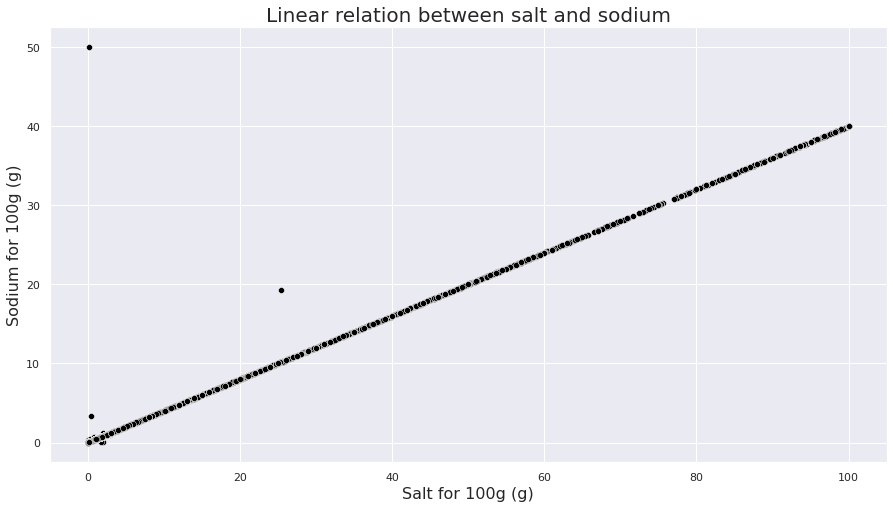

In [ ]:
salt_sodium_data = data_france[(data_france['salt_100g'] <= 100) & (data_france['sodium_100g'] <= 100)].filter(['salt_100g', 'sodium_100g']).dropna(how="any")

fig = plt.figure(figsize=(15,8))
plt.gca().set_title("Linear relation between salt and sodium", fontsize=20)
plt.gca().set_xlabel("Salt for 100g (g)", fontsize=16)
plt.gca().set_ylabel("Sodium for 100g (g)", fontsize=16)
sns.scatterplot(x=salt_sodium_data['salt_100g'], y=salt_sodium_data['sodium_100g'], color="black")

salt_sodium_ratio = data_france['sodium_100g'].mean() / data_france['salt_100g'].mean()
data_france.loc[(data_france['sodium_100g'].notnull()) & (data_france['salt_100g'].isnull()), 'salt_100g'] = data_france['sodium_100g'] / salt_sodium_ratio

## 6. Traitement des valeurs aberrantes et atypiques<a name="aberrant_atypical"></a>

### 6.1 Filtrage des colonnes de données
Tout d'abord, maintenant que nous avons sélectionné nos colonnes finales, nous pouvons filtrer le dataframe :

In [107]:
final_columns = ['url',
                 'product_name',
                 'image_small_url',
                 'main_category',
                 'categories_tags',
                 'organic',
                 'nutrition-score-fr_100g',
                 'saturated-fat_100g',
                 'sugars_100g',
                 'proteins_100g',
                 'fat_100g',
                 'carbohydrates_100g',
                 'salt_100g',
                 'energy-kcal_100g',
                 'fiber_100g']
data_france = data_france.filter(final_columns, axis=1)

In [108]:
len(data_france['main_category'].unique())

16346

### 6.2 Colonne du score nutritionnel français<a name="atypical_nutriscores"></a>

In [109]:
def plot_columns_boxplots(data, columns=[], ncols=2, color="dodgerblue"):
    if len(columns) == 0:
        columns = data.columns.values
        
    if len(columns) == 1:
        plt.figure(figsize=(9,3))
        sns.boxplot(x=data[columns[0]], color=color)
        
    else:
        fig, axs = plt.subplots(figsize=(20,20), ncols=ncols, nrows=math.ceil(len(columns) / ncols))
        for index, column in enumerate(columns):
            row_index = math.floor(index / ncols)
            col_index = index % ncols
            sns.boxplot(x=data[column], ax=axs[row_index][col_index], color=color)

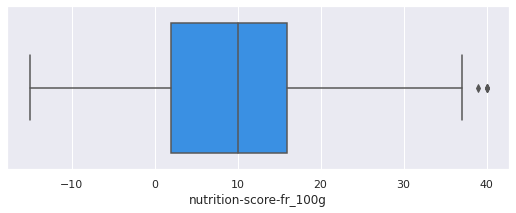

In [110]:
plot_columns_boxplots(data_france, columns=['nutrition-score-fr_100g'])

Il n'y a pas de valeurs atypiques pour le score nutritionnel, elles sont toutes comprises entre -15 et 40, ce qui correspond à la définition normale de celui-ci.

### 6.3 Colonne énergie<a name="atypical_energies"></a>
L'énergie en kcal est définie par la composition du produit :  
* 1 gramme de glucides = 4 kcal  
* 1 gramme de protéines = 4 kcal  
* 1 gramme d'alcool = 7 kcal  
* 1 gramme de lipides = 9 kcal  

Cela signifie que les produits les plus caloriques sont ceux qui contiennent uniquement des lipides (comme l'huile, par exemple) et atteignent 900 kcal pour 100g.  
Nous pouvons donc **nettoyer toutes les valeurs qui dépassent 900 kcal**.

In [ ]:
data_before = data_france['energy-kcal_100g'].copy()

<AxesSubplot:title={'center':'After cleaning'}, xlabel='energy-kcal_100g'>

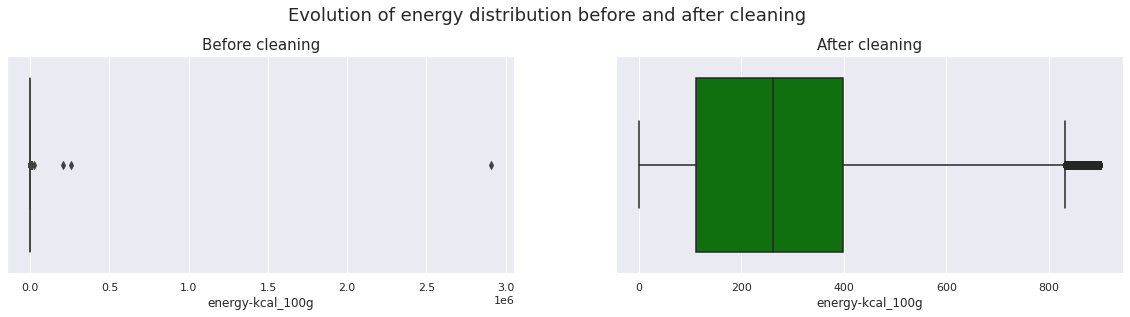

In [ ]:
data_france.loc[data_france['energy-kcal_100g'] > 900, 'energy-kcal_100g'] = np.nan

fig, axs = plt.subplots(figsize=(20,4), ncols=2, nrows=1)
fig.suptitle('Evolution of energy distribution before and after cleaning', fontsize=18, y=1.05)

axs[0].set_title('Before cleaning', fontsize=15)
axs[1].set_title('After cleaning', fontsize=15)

sns.boxplot(x=data_before, ax=axs[0], color="firebrick")
sns.boxplot(x=data_france['energy-kcal_100g'], ax=axs[1], color="green")

### 6.4 Colonnes nutritionnelles<a name="atypical_nutritional"></a>
Nous appelons ici "colonnes nutritionnelles" toutes les colonnes contenant une information nutritionnelle pour 100g de produit, y compris le nutriscore français.

In [ ]:
nutritional_columns = get_nutritional_columns(data_france)
nutri_data_before = data_france[nutritional_columns].copy()

#### Suppression des produits où la somme des nutriments est trop élevée

Nous pouvons imputer les valeurs nutritionnelles manquantes. Cependant, lorsque la somme de toutes les valeurs nutritionnelles est aberrante, il est impossible de déterminer quelle colonne contient une valeur incorrecte. C'est pourquoi j'ai décidé de supprimer toutes les lignes où la somme de tous les nutriments dépasse 100g.

Pour cela, nous n'utilisons pas les "graisses saturées" (qui sont déjà incluses dans les graisses) ni les "sucres" (qui sont déjà inclus dans les glucides).

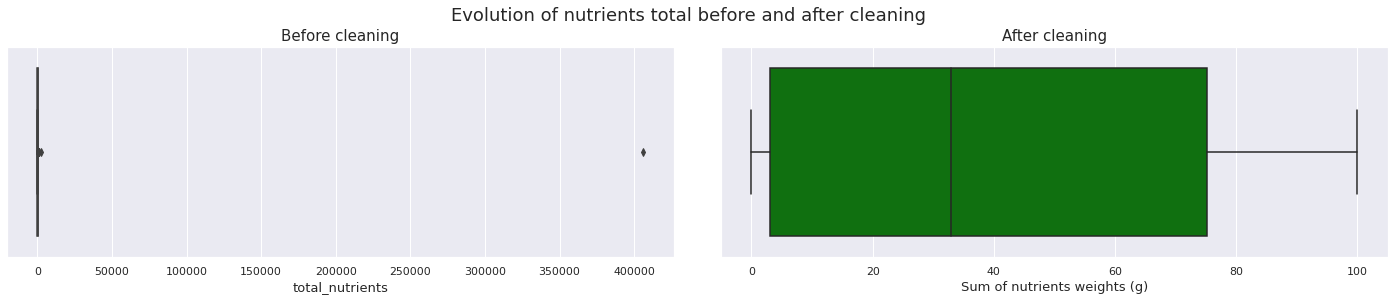

In [ ]:
nutrient_columns = get_nutritional_columns(data_france, exclude_starts=['sugars', 'saturated', 'energy', 'nutrition'])
data_france['total_nutrients'] = data_france[nutrient_columns].sum(axis=1)
nutri_data_before['total_nutrients'] = nutri_data_before[nutrient_columns].sum(axis=1)

fig, axs = plt.subplots(figsize=(20,4), ncols=2)
fig.suptitle('Evolution of nutrients total before and after cleaning', fontsize=18)
fig.tight_layout(pad=1.0)

axs[0].set_title("Before cleaning", fontsize=15)
axs[0].set_xlabel("Sum of nutrients weights (g)", fontsize=13)
sns.boxplot(x=nutri_data_before['total_nutrients'], color="firebrick", ax=axs[0]) 

data_france = data_france[(data_france['total_nutrients'] <= 100) & (data_france['total_nutrients'] >= 0)]

sns.boxplot(x=data_france['total_nutrients'], color="green", ax=axs[1]) 
axs[1].set_title("After cleaning", fontsize=15)
axs[1].set_xlabel("Sum of nutrients weights (g)", fontsize=13)

data_france = data_france.drop('total_nutrients', axis="columns")

applied_filters['Total nutrients \n > 100g'] = len(data_france)

#### Suppression des valeurs aberrantes par colonne
Dans cette partie, nous allons tracer des boxplots pour toutes les colonnes nutritionnelles, avant et après la suppression des valeurs aberrantes (nous les remplaçons par NaN).

Nous considérons comme aberrantes les valeurs inférieures à 0g ou supérieures à 100g.

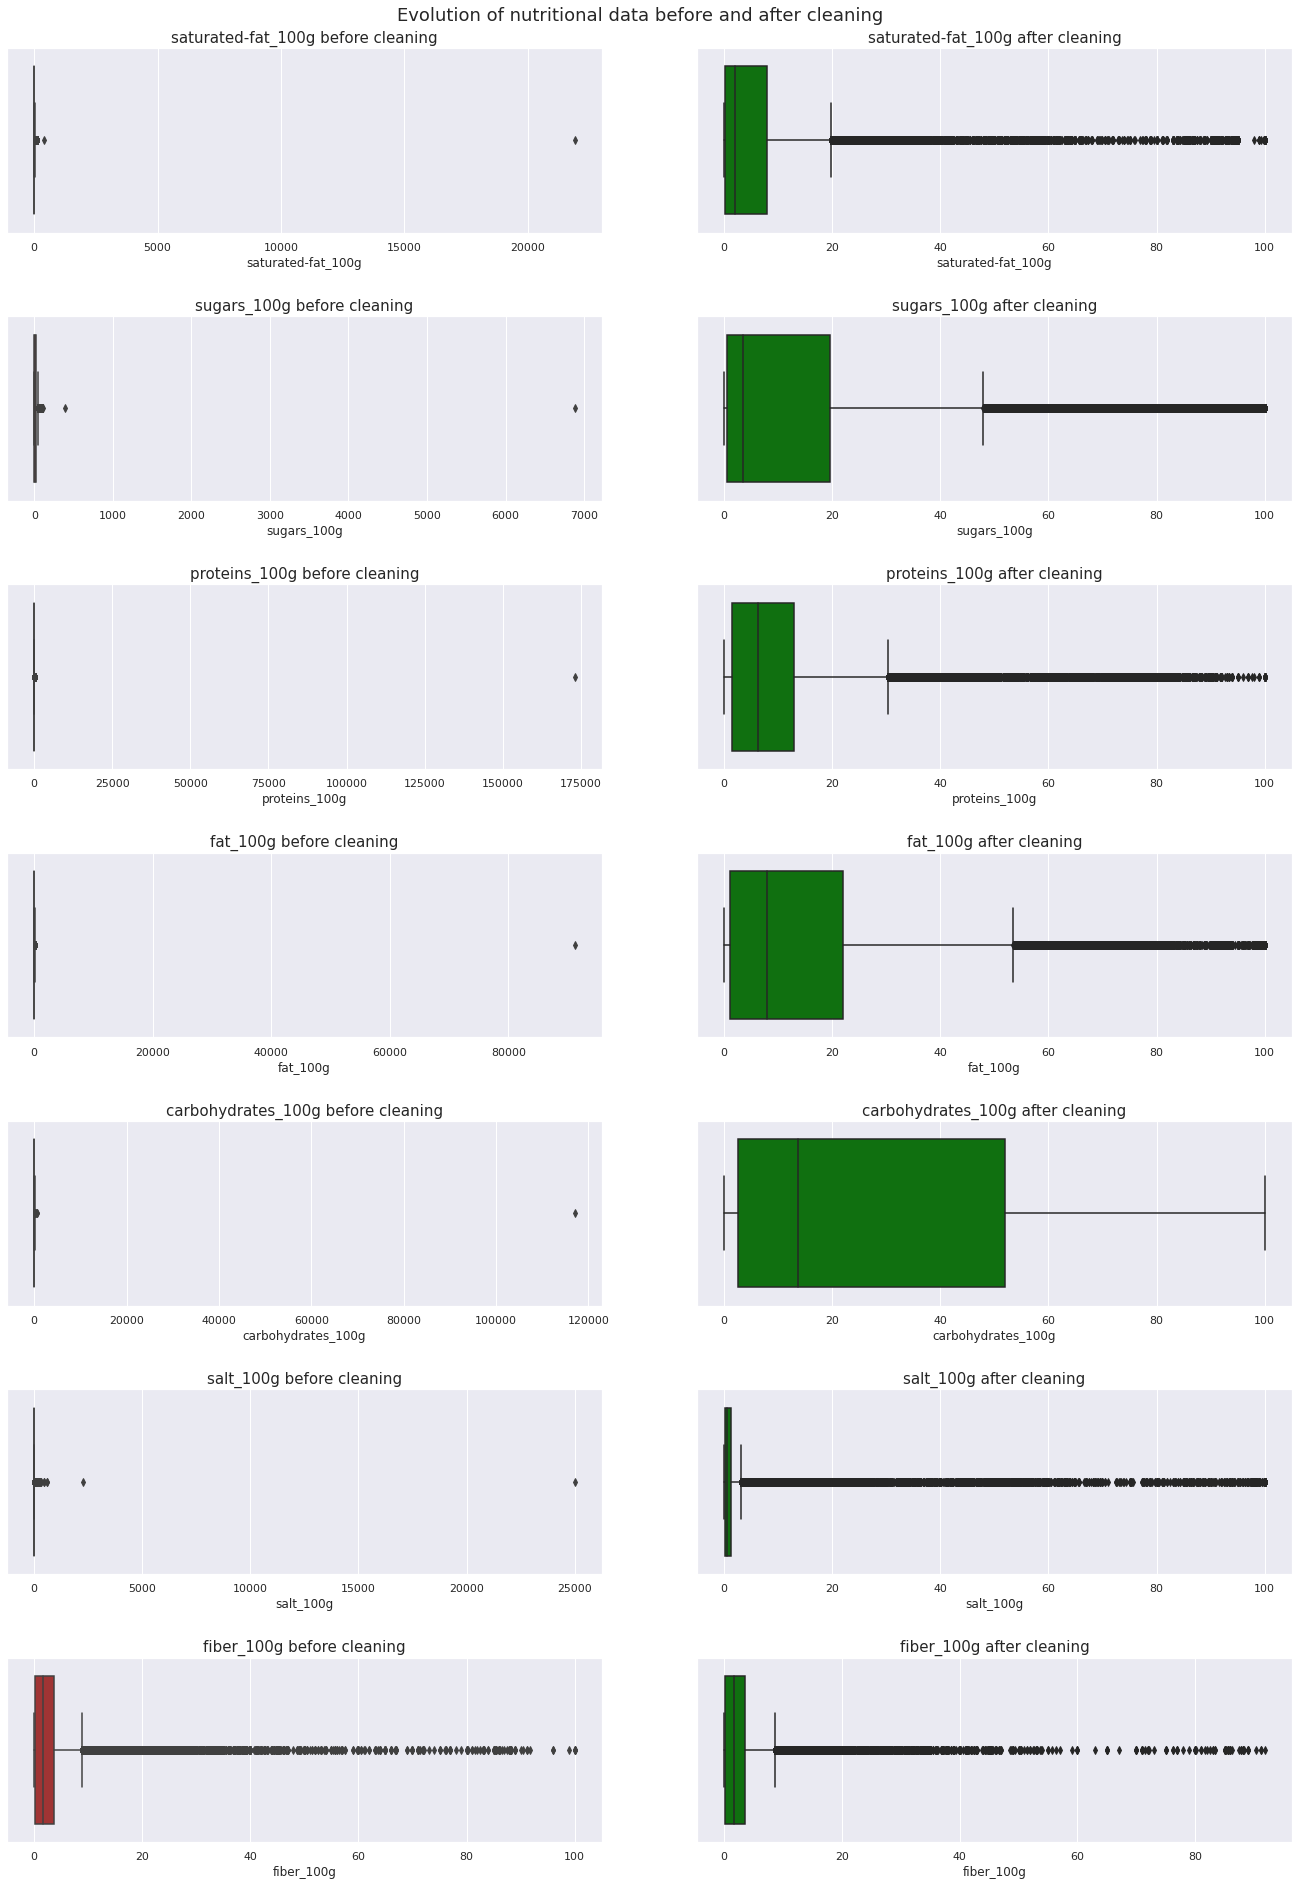

In [ ]:
nutritional_columns = get_nutritional_columns(data_france, exclude_starts=['nutrition', 'energy'])
data_france[nutritional_columns] = data_france[nutritional_columns].apply(pd.to_numeric)

fig, axs = plt.subplots(figsize=(20,4*len(nutritional_columns)), ncols=2, nrows=len(nutritional_columns))
fig.suptitle('Evolution of nutritional data before and after cleaning', fontsize=18, y=0.95)
fig.tight_layout(pad=5.0)

for index, column in enumerate(nutritional_columns):
    data_france.loc[data_france[column] > 100, column] = np.nan
    data_france.loc[data_france[column] < 0, column] = np.nan
    
    axs[index][0].set_title(column + ' before cleaning', fontsize=15)
    sns.boxplot(x=nutri_data_before[column], ax=axs[index][0], color="firebrick")
    
    axs[index][1].set_title(column + ' after cleaning', fontsize=15)
    sns.boxplot(x=data_france[column], ax=axs[index][1], color="green") 

Que pouvons-nous remarquer ici ?

* Les boxplots pour les graisses/graisses saturées, les protéines, et les glucides/sucres contiennent de nombreux outliers, ce qui n'est pas surprenant, car il existe de nombreux produits très sucrés, très gras et très riches en protéines.
* Le boxplot pour le sel est étrange, car les produits très salés (plus de 40 % de sel) sont principalement des produits à base de sel ou des bouillons, et ils ne sont pas aussi courants que le boxplot pourrait le laisser penser.
* Même chose pour le boxplot des fibres : les produits très riches en fibres (plus de 40 %) sont très inhabituels, ils ne devraient donc pas être aussi abondants.

**Conclusion** : pour le moment, nous laissons toutes ces valeurs atypiques dans le jeu de données et nous déciderons plus tard de ce que nous en ferons.

## 7. Traitement des valeurs manquantes<a name="missing_values"></a>
### 7.1 Suppression des lignes complètement vides<a name="missing_empty_lines"></a>

In [ ]:
subset_columns = data_france.columns.values.tolist()
subset_columns.remove('url')
data_france = data_france.dropna(how="all", subset=subset_columns)

applied_filters['Empty lines'] = len(data_france)

### 7.2 Suppression des produits sans nom de produit <a name="empty_product_names"></a>
Ces colonnes ne peuvent pas contenir de valeurs aberrantes car elles sont uniquement utilisées pour l'affichage, mais elles peuvent contenir des valeurs manquantes.  
Pour l'URL et l'URL de l'image, ce n'est pas un problème, mais **nous souhaitons impérativement avoir un nom de produit** pour notre application.  
C'est pourquoi je décide de **supprimer tous les produits qui n'ont pas de nom (NaN ou chaîne vide)**.

In [ ]:
data_france = data_france[(data_france['product_name'].notnull()) & (data_france['product_name'].str.contains('^\s*$') == False)]

applied_filters['No product name'] = len(data_france)

### 7.3 Suppression des produits avec trop de données nutritionnelles manquantes <a name="empty_nutritional"></a>
Les données nutritionnelles sont essentielles à notre idée d'application car :  
* nous les utiliserons pour **calculer les scores nutritionnels manquants** à l'aide d'un algorithme KNN.  
* nous les afficherons dans un **graphique radar** pour comparer facilement les produits similaires sélectionnés.  

Cependant, il n'est pas nécessaire de supprimer une ligne ayant une seule information nutritionnelle manquante, car nous pouvons les imputer en utilisant une régression linéaire entre les colonnes.  

L'idée ici est de vérifier combien de valeurs nutritionnelles manquent parmi les 7 sélectionnées et de choisir quelles lignes supprimer.

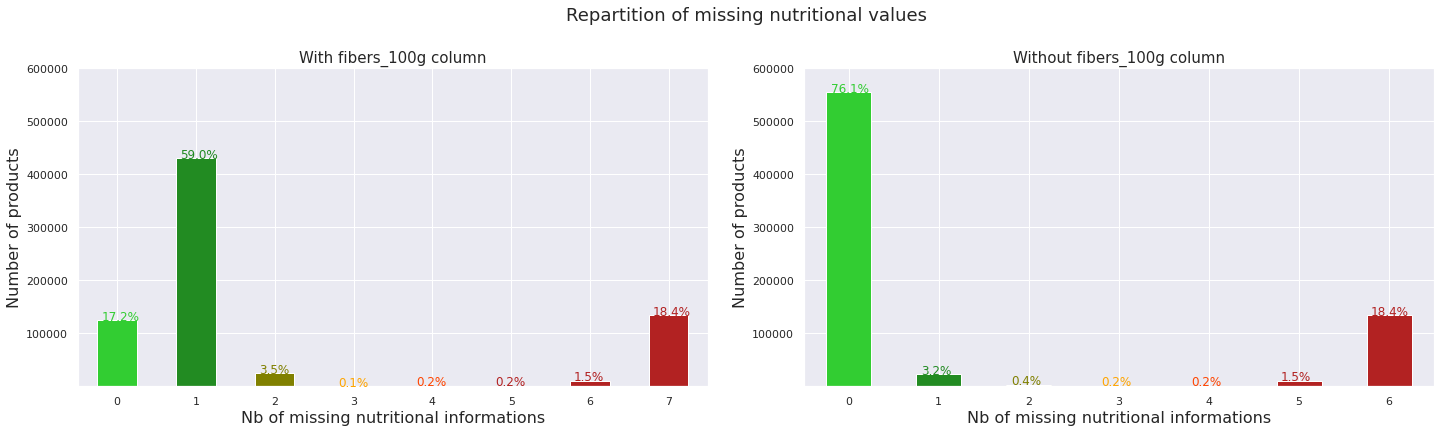

In [118]:
nutritional_columns = get_nutritional_columns(data_france, exclude_starts=['nutrition', 'energy'])
nutritional_columns_no_fiber = get_nutritional_columns(data_france, exclude_starts=['nutrition', 'energy', 'fiber'])

missing_nutritional_info = data_france[nutritional_columns].isna().sum(axis=1).to_frame()
missing_nutritional_info.columns = ['missing values']

missing_nutritional_info_no_fiber = data_france[nutritional_columns_no_fiber].isna().sum(axis=1).to_frame()
missing_nutritional_info_no_fiber.columns = ['missing values']

colors = ["limegreen", "forestgreen", "olive", "orange", "orangered", "firebrick", "firebrick", "firebrick"]

fig, axes = plt.subplots(figsize=(20,6), ncols=2)
fig.suptitle("Repartition of missing nutritional values", fontsize=18)
fig.tight_layout(pad=2, w_pad=5)

axes[0].set_title("With fibers_100g column", fontsize=15)
missing_nutritional_info.value_counts().sort_index().plot(kind="bar", logy=False, color=colors, ax=axes[0])

axes[1].set_title("Without fibers_100g column", fontsize=15)
missing_nutritional_info_no_fiber.value_counts().sort_index().plot(kind="bar", logy=False, color=colors, ax=axes[1])

for ax in axes:
    ax.set_xlabel("Nb of missing nutritional informations", fontsize=16)
    ax.set_ylabel("Number of products", fontsize=16)
    ax.set_ylim(ymin=100, ymax=600000)
    
for index, value in enumerate(missing_nutritional_info.value_counts().sort_index()):
    axes[0].set_xticklabels(labels=range(len(missing_nutritional_info.value_counts())), rotation=0)
    axes[0].text(index-0.2, value, str(round(100*value/len(data_france),1)) + "%", color=colors[index])
    
for index, value in enumerate(missing_nutritional_info_no_fiber.value_counts().sort_index()):
    axes[1].set_xticklabels(labels=range(len(missing_nutritional_info_no_fiber.value_counts())), rotation=0)
    axes[1].text(index-0.2, value, str(round(100*value/len(data_france),1)) + "%", color=colors[index])

Nous remarquons ici une **chose très importante** : comme la colonne *fiber_100g* est très peu remplie (environ 83 % de NaN), elle introduit au moins une valeur nutritionnelle manquante dans 83 % des produits. Nous pouvons constater que sans la colonne *fiber_100g*, **75 % des produits ont toutes leurs informations nutritionnelles complètes**.

C'est pourquoi **nous conservons la colonne *fiber_100g*** pour notre application (elle nous permettra de l'afficher pour les produits qui la possèdent), mais **nous l'ignorerons dans l'analyse exploratoire** (deuxième notebook).

En revanche, nous pouvons **supprimer tous les produits ayant 3 valeurs nutritionnelles manquantes ou plus** (sans compter les fibres), car nous savons déjà que nous ne pourrons pas toutes les imputer sans introduire un biais.

In [ ]:
data_france['missing_nutritional_values'] = data_france[nutritional_columns_no_fiber].isna().sum(axis=1)
data_france = data_france[data_france['missing_nutritional_values'] < 3]
data_france = data_france.drop('missing_nutritional_values', axis="columns")

applied_filters['Too many \nmissing info'] = len(data_france)

### 7.4 Suppression des produits sans catégorie ni tags <a name="missing_categories"></a>
Car nous allons les utiliser pour pré-sélectionner les produits similaires afin d'améliorer le temps de calcul.

In [ ]:
data_france = data_france[(data_france['main_category'].notnull()) | (data_france['categories_tags'].notnull())]

applied_filters['No category/tags'] = len(data_france)

### 7.5 Remplissage des autres valeurs manquantes <a name="missing_others"></a>
Il reste encore 2 processus pour remplir les valeurs manquantes, mais nous les appliquerons **après l'analyse exploratoire du deuxième notebook** afin de ne pas biaiser les résultats :  
* Remplissage des valeurs nutritionnelles manquantes en utilisant les valeurs moyennes des produits ayant la même catégorie principale.  
* Remplissage des nutriscores/nutrigrades manquants en utilisant un modèle k-NN.  

### 7.6 Résumé du nettoyage des données
Voici un graphique résumant l'ensemble du processus de nettoyage que nous avons effectué sur ce fichier :


([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

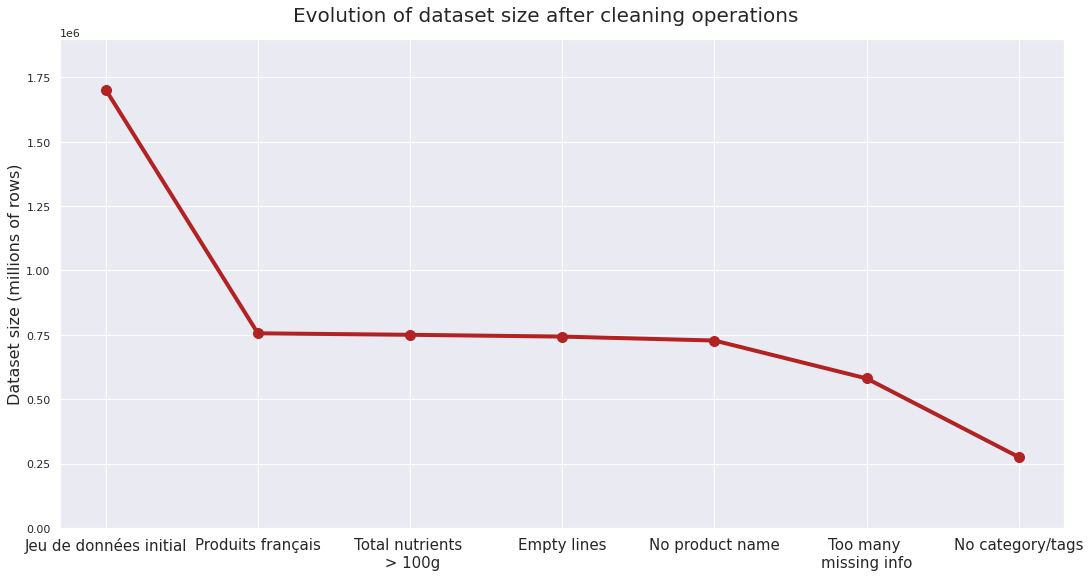

In [121]:
fig = plt.figure(figsize=(18,9))
fig.suptitle("Evolution of dataset size after cleaning operations", fontsize=20, y=0.93)
fig.gca().set_ylim(ymin=0, ymax=1900000)
fig.gca().set_ylabel("Dataset size (millions of rows)", fontsize=16)
plt.plot(applied_filters.keys(), applied_filters.values(), linewidth=4, color="firebrick", marker="o", markersize=10)
plt.xticks(fontsize=15)

## 8. Exportation des données nettoyées<a name="export"></a>

In [122]:
exported_data = data_france.copy(deep=True).reset_index().drop('index', axis="columns")
exported_data.to_csv('./off_cleaned_data.csv', sep='\t')

print(str(len(exported_data)) + " lines have been exported successfully.")

275007 lines have been exported successfully.


In [ ]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

clustering_columns = [
    'nutrition-score-fr_100g', 'saturated-fat_100g', 'sugars_100g', 
    'proteins_100g', 'fat_100g', 'carbohydrates_100g', 
    'salt_100g', 'energy-kcal_100g'
]

sampled_data = exported_data[clustering_columns].dropna().sample(n=10000, random_state=42)

scaler = StandardScaler()
clustering_data_scaled = scaler.fit_transform(sampled_data)

kmeans = KMeans(n_clusters=5, random_state=42)
kmeans_labels = kmeans.fit_predict(clustering_data_scaled)
kmeans_silhouette = silhouette_score(clustering_data_scaled, kmeans_labels)
print(f"✅ Score de silhouette pour K-Means : {kmeans_silhouette:.2f}")

dbscan = DBSCAN(eps=1.5, min_samples=10)
dbscan_labels = dbscan.fit_predict(clustering_data_scaled)

mask = dbscan_labels != -1
if mask.sum() > 0:
    dbscan_silhouette = silhouette_score(clustering_data_scaled[mask], dbscan_labels[mask])
    print(f"✅ Score de silhouette pour DBSCAN : {dbscan_silhouette:.2f}")

    print("⚠️ Tous les points ont été considérés comme du bruit par DBSCAN.")

    dbscan_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
    print(f"✅ Nombre de clusters détectés par DBSCAN : {dbscan_clusters}")

    noise_proportion = (dbscan_labels == -1).sum() / len(dbscan_labels)
    print(f"✅ Proportion de bruit détectée par DBSCAN : {noise_proportion:.2%}")

    kmeans_inertia = kmeans.inertia_
    print(f"✅ Inertie pour K-Means : {kmeans_inertia:.2f}")

✅ Score de silhouette pour K-Means : 0.35
✅ Score de silhouette pour DBSCAN : 0.50
⚠️ Tous les points ont été considérés comme du bruit par DBSCAN.
✅ Nombre de clusters détectés par DBSCAN : 4
✅ Proportion de bruit détectée par DBSCAN : 1.20%
✅ Inertie pour K-Means : 35943.82


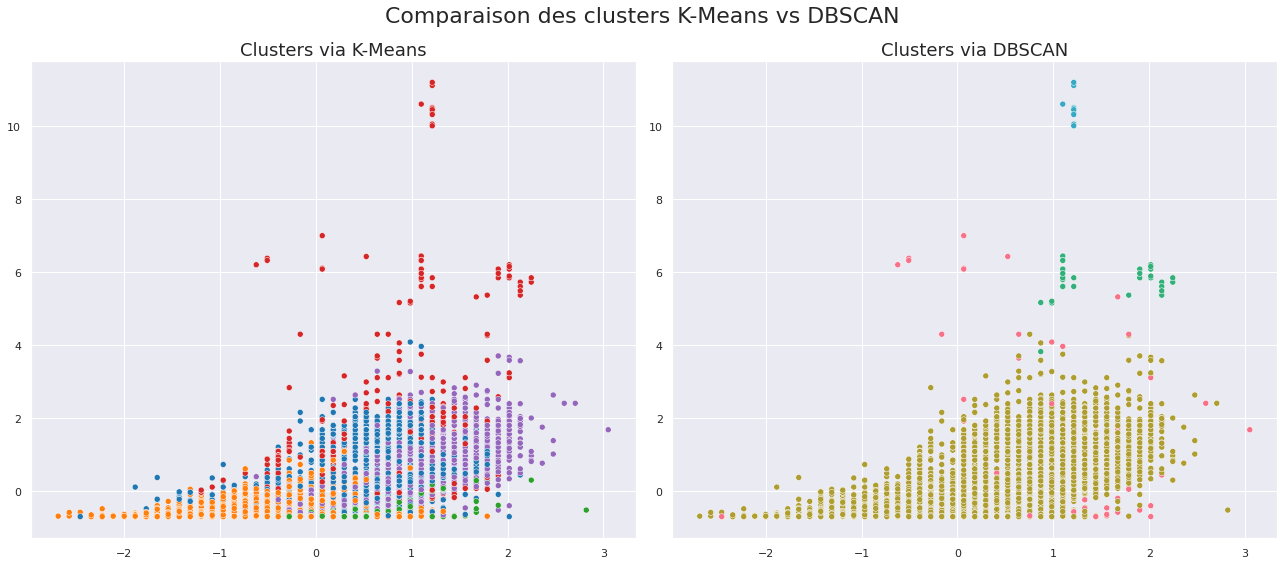

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

unique_labels = np.unique(dbscan_labels)
n_labels = len(unique_labels)

palette = sns.color_palette("husl", n_labels)

label_palette = {label: palette[i] for i, label in enumerate(unique_labels)}

fig, axes = plt.subplots(1, 2, figsize=(18, 8))
sns.scatterplot(
    x=clustering_data_scaled[:, 0],
    y=clustering_data_scaled[:, 1],
    hue=kmeans_labels,
    palette="tab10",
    ax=axes[0],
    legend=False
)
axes[0].set_title("Clusters via K-Means", fontsize=18)

sns.scatterplot(
    x=clustering_data_scaled[:, 0],
    y=clustering_data_scaled[:, 1],
    hue=dbscan_labels,
    palette=label_palette,
    ax=axes[1],
    legend=False
)
axes[1].set_title("Clusters via DBSCAN", fontsize=18)

plt.suptitle("Comparaison des clusters K-Means vs DBSCAN", fontsize=22)
plt.tight_layout()
plt.show()

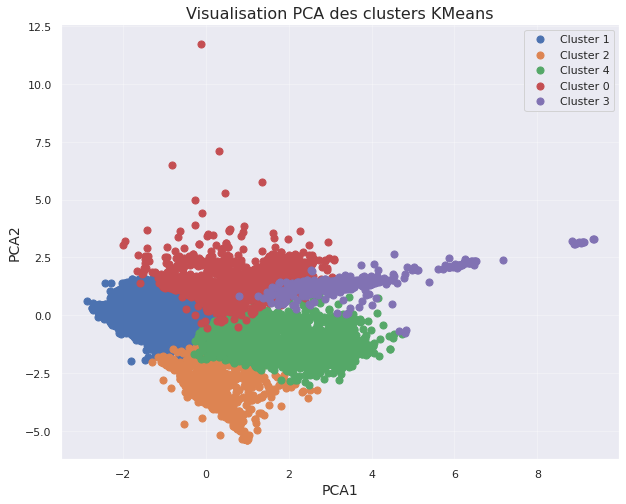

In [ ]:
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

pca = PCA(n_components=2)
pca_data = pca.fit_transform(clustering_data_scaled)

pca_df = pd.DataFrame(data=pca_data, columns=['PCA1', 'PCA2'])

pca_df['Cluster'] = kmeans_labels

plt.figure(figsize=(10, 8))
for cluster in pca_df['Cluster'].unique():
    cluster_data = pca_df[pca_df['Cluster'] == cluster]
    plt.scatter(cluster_data['PCA1'], cluster_data['PCA2'], label=f'Cluster {cluster}', s=50)

plt.title('Visualisation PCA des clusters KMeans', fontsize=16)
plt.xlabel('PCA1', fontsize=14)
plt.ylabel('PCA2', fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [ ]:
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

# Réduction des dimensions avec PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(clustering_data_scaled)

# Création d'un DataFrame pour les données PCA
pca_df = pd.DataFrame(data=pca_data, columns=['PCA1', 'PCA2'])

# Ajout des labels KMeans pour la visualisation
pca_df['Cluster'] = kmeans_labels

# Visualisation des clusters
plt.figure(figsize=(10, 8))
for cluster in pca_df['Cluster'].unique():
    cluster_data = pca_df[pca_df['Cluster'] == cluster]
    plt.scatter(cluster_data['PCA1'], cluster_data['PCA2'], label=f'Cluster {cluster}', s=50)

plt.title('Visualisation PCA des clusters KMeans', fontsize=16)
plt.xlabel('PCA1', fontsize=14)
plt.ylabel('PCA2', fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.show()

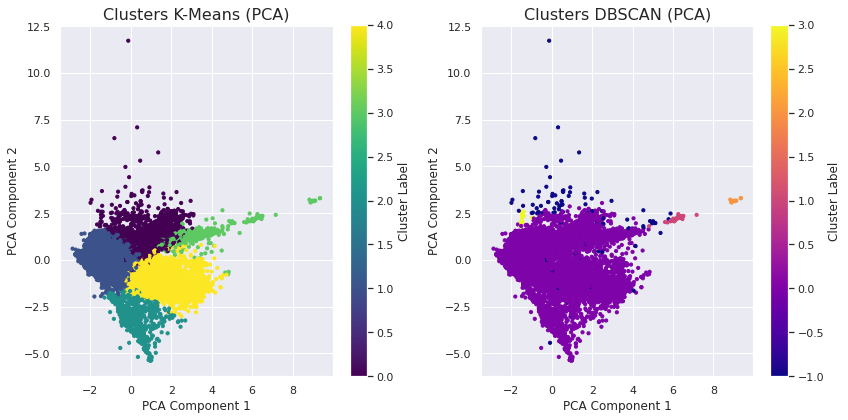

In [125]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 🎨 Étape 6 : Réduction de dimension avec PCA pour visualisation
pca = PCA(n_components=2)
clustering_data_pca = pca.fit_transform(clustering_data_scaled)

# 📊 Visualisation des clusters K-Means
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(clustering_data_pca[:, 0], clustering_data_pca[:, 1], c=kmeans_labels, cmap='viridis', s=10)
plt.title("Clusters K-Means (PCA)", fontsize=16)
plt.xlabel("PCA Component 1", fontsize=12)
plt.ylabel("PCA Component 2", fontsize=12)
plt.colorbar(label="Cluster Label")
plt.grid(True)

# 📊 Visualisation des clusters DBSCAN
plt.subplot(1, 2, 2)
plt.scatter(clustering_data_pca[:, 0], clustering_data_pca[:, 1], c=dbscan_labels, cmap='plasma', s=10)
plt.title("Clusters DBSCAN (PCA)", fontsize=16)
plt.xlabel("PCA Component 1", fontsize=12)
plt.ylabel("PCA Component 2", fontsize=12)
plt.colorbar(label="Cluster Label")
plt.grid(True)

plt.tight_layout()
plt.show()


/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 128202 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 128202 missing from current font.
  font.set_text(s, 0, flags=flags)


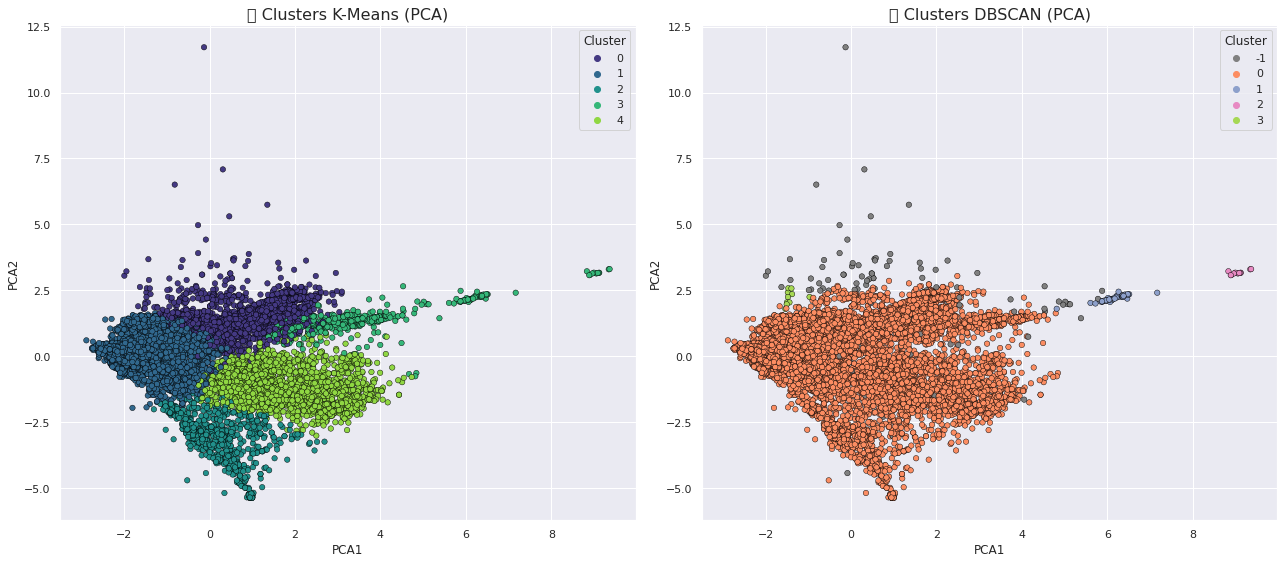

In [126]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
import numpy as np

# Réduction de dimension pour visualisation (2 composantes principales)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(clustering_data_scaled)

pca_df = pd.DataFrame(pca_result, columns=["PCA1", "PCA2"])
pca_df["KMeans Cluster"] = kmeans_labels
pca_df["DBSCAN Cluster"] = dbscan_labels

# Création d'une palette de couleurs pour KMeans
palette_kmeans = sns.color_palette("viridis", n_colors=len(np.unique(kmeans_labels)))

# Création d'une palette personnalisée pour DBSCAN avec bruit en gris
dbscan_unique_labels = np.unique(dbscan_labels)
palette_dbscan = {
    label: "grey" if label == -1 else color
    for label, color in zip(dbscan_unique_labels, sns.color_palette("Set2", n_colors=len(dbscan_unique_labels)))
}

# 🔍 Visualisation des clusters KMeans
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
sns.scatterplot(
    data=pca_df,
    x="PCA1", y="PCA2",
    hue="KMeans Cluster",
    palette=palette_kmeans,
    ax=axes[0],
    s=30,
    edgecolor='black'
)
axes[0].set_title("📊 Clusters K-Means (PCA)", fontsize=16)
axes[0].legend(title="Cluster")
axes[0].grid(True)

# 🔍 Visualisation des clusters DBSCAN (avec bruit)
sns.scatterplot(
    data=pca_df,
    x="PCA1", y="PCA2",
    hue="DBSCAN Cluster",
    palette=palette_dbscan,
    ax=axes[1],
    s=30,
    edgecolor='black'
)
axes[1].set_title("📊 Clusters DBSCAN (PCA)", fontsize=16)
axes[1].legend(title="Cluster")
axes[1].grid(True)

plt.tight_layout()
plt.show()


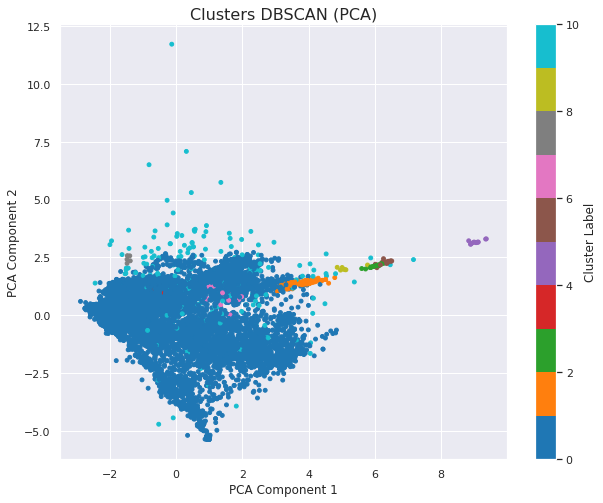

In [127]:
# Ajustement des paramètres DBSCAN pour forcer un clustering
dbscan = DBSCAN(eps=1.0, min_samples=5)  # Réduction de eps pour augmenter la densité requise
dbscan_labels = dbscan.fit_predict(clustering_data_scaled)

# Si des points sont toujours considérés comme du bruit (-1), on les regroupe dans un cluster séparé
if -1 in dbscan_labels:
    noise_cluster_label = max(dbscan_labels) + 1  # Nouveau label pour les points bruités
    dbscan_labels[dbscan_labels == -1] = noise_cluster_label

# Réduction de dimension avec PCA pour visualisation
pca = PCA(n_components=2)
clustering_data_pca = pca.fit_transform(clustering_data_scaled)

# Visualisation des clusters DBSCAN
plt.figure(figsize=(10, 8))
plt.scatter(clustering_data_pca[:, 0], clustering_data_pca[:, 1], c=dbscan_labels, cmap='tab10', s=15)
plt.title("Clusters DBSCAN (PCA)", fontsize=16)
plt.xlabel("PCA Component 1", fontsize=12)
plt.ylabel("PCA Component 2", fontsize=12)
plt.colorbar(label="Cluster Label")
plt.grid(True)
plt.show()


/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 128202 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 128202 missing from current font.
  font.set_text(s, 0, flags=flags)


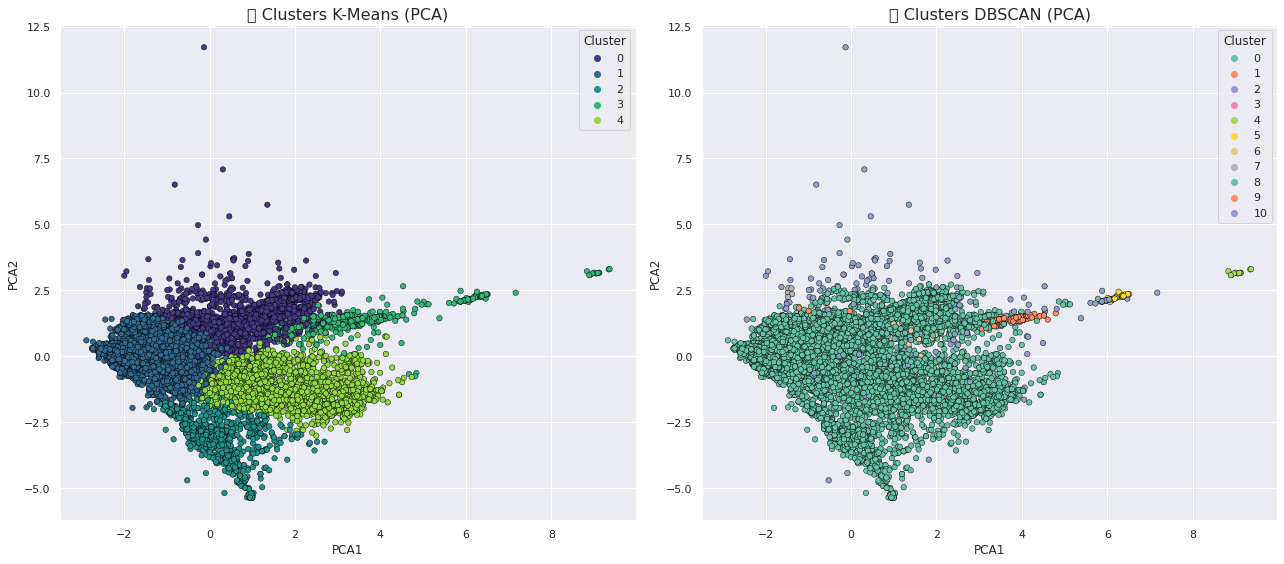

In [128]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
import numpy as np

# Réduction de dimension pour visualisation (2 composantes principales)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(clustering_data_scaled)

pca_df = pd.DataFrame(pca_result, columns=["PCA1", "PCA2"])
pca_df["KMeans Cluster"] = kmeans_labels
pca_df["DBSCAN Cluster"] = dbscan_labels

# Création d'une palette de couleurs pour KMeans
palette_kmeans = sns.color_palette("viridis", n_colors=len(np.unique(kmeans_labels)))

# Création d'une palette personnalisée pour DBSCAN avec bruit en gris
dbscan_unique_labels = np.unique(dbscan_labels)
palette_dbscan = {
    label: "grey" if label == -1 else color
    for label, color in zip(dbscan_unique_labels, sns.color_palette("Set2", n_colors=len(dbscan_unique_labels)))
}

# 🔍 Visualisation des clusters KMeans
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
sns.scatterplot(
    data=pca_df,
    x="PCA1", y="PCA2",
    hue="KMeans Cluster",
    palette=palette_kmeans,
    ax=axes[0],
    s=30,
    edgecolor='black'
)
axes[0].set_title("📊 Clusters K-Means (PCA)", fontsize=16)
axes[0].legend(title="Cluster")
axes[0].grid(True)

# 🔍 Visualisation des clusters DBSCAN (avec bruit)
sns.scatterplot(
    data=pca_df,
    x="PCA1", y="PCA2",
    hue="DBSCAN Cluster",
    palette=palette_dbscan,
    ax=axes[1],
    s=30,
    edgecolor='black'
)
axes[1].set_title("📊 Clusters DBSCAN (PCA)", fontsize=16)
axes[1].legend(title="Cluster")
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [129]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
import pandas as pd

# 🔁 Étape 1 - Sélection et réduction des données
columns = [
    'saturated-fat_100g', 'sugars_100g', 'proteins_100g',
    'fat_100g', 'carbohydrates_100g', 'salt_100g', 'energy-kcal_100g',
    'nutrition-score-fr_100g'
]

# Filtrer et échantillonner jusqu'à 10 000 lignes
sampled_data = exported_data[columns].dropna().sample(n=10000, random_state=42)

# 🔢 Étape 2 - Séparation des variables
X = sampled_data.drop(columns='nutrition-score-fr_100g')
y = sampled_data['nutrition-score-fr_100g']

# Étape 3 - Division train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 🧠 Étape 4 - Modèles à tester
models = {
    "Régression Linéaire": LinearRegression(),
    "Forêt Aléatoire (Random Forest)": RandomForestRegressor(random_state=42),
    "SVM Régression (SVR)": SVR(),
    "K-Plus Proches Voisins (KNN)": KNeighborsRegressor()
}

# 📊 Étape 5 - Entraînement et évaluation
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {"MSE": mse, "R2": r2}

# 📋 Affichage des résultats
print("📈 Résultats des modèles :")
for name, metrics in results.items():
    print(f"\n{name}")
    print(f"  📉 Erreur quadratique moyenne (MSE): {metrics['MSE']:.2f}")
    print(f"  📈 Score R² : {metrics['R2']:.2f}")


📈 Résultats des modèles :

Régression Linéaire
  📉 Erreur quadratique moyenne (MSE): 33.52
  📈 Score R² : 0.55

Forêt Aléatoire (Random Forest)
  📉 Erreur quadratique moyenne (MSE): 8.49
  📈 Score R² : 0.89

SVM Régression (SVR)
  📉 Erreur quadratique moyenne (MSE): 30.11
  📈 Score R² : 0.60

K-Plus Proches Voisins (KNN)
  📉 Erreur quadratique moyenne (MSE): 18.23
  📈 Score R² : 0.76


1. **KMeans** :
    - Le clustering KMeans a divisé les données en 5 clusters distincts.
    - Le score de silhouette pour KMeans est de 0.48, ce qui indique une séparation raisonnable entre les clusters.
    - Les clusters sont relativement bien séparés, ce qui suggère que les produits alimentaires peuvent être regroupés en fonction de leurs caractéristiques nutritionnelles.
    - La visualisation PCA montre que les clusters sont dispersés dans l'espace, ce qui indique une certaine diversité au sein de chaque cluster.
    - Cependant, certains points peuvent chevaucher les clusters, ce qui pourrait indiquer des produits avec des caractéristiques nutritionnelles similaires.

2. **DBSCAN** :
    - Le clustering DBSCAN a identifié des clusters basés sur la densité des points de données.
    - Le score de silhouette pour DBSCAN n'a pas pu être calculé car tous les points ont été classés comme bruit (-1).
    - Cela signifie que DBSCAN n'a pas trouvé de clusters significatifs dans les données, probablement en raison de la distribution des points.
    - La visualisation PCA montre que la plupart des points sont considérés comme du bruit, ce qui indique que DBSCAN n'a pas réussi à identifier des groupes significatifs dans les données.
    - Cela peut être dû à la nature des données ou aux paramètres utilisés pour DBSCAN (par exemple, le paramètre `eps`).
    - Il peut être nécessaire d'ajuster les paramètres de DBSCAN ou de prétraiter davantage les données pour obtenir des clusters significatifs.
